Code from https://www.kaggle.com/code/mohamedmagdy191/traffic-signs-recognition-resnet-from-scratch

# Import Required Libraries 

In [1]:
import os
import random
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from PIL import Image

In [2]:
%%capture
# Use code from other notebook
%run ./ResNet.ipynb

In [3]:
from dotenv import load_dotenv
# Load .env files
try:
    load_dotenv()
except:
    print("Couldn't load .env file")

# Get environmet variables
traffic_sign_dataset_dir = os.getenv('TRAFFIC_SIGN_DIR', "")

# Loading The Data

In [4]:
meta_df = pd.read_csv(traffic_sign_dataset_dir + '/Meta.csv')
train_df = pd.read_csv(traffic_sign_dataset_dir + '/Train.csv')
test_df = pd.read_csv(traffic_sign_dataset_dir + '/Test.csv')

In [5]:
train_data_path = os.path.join(traffic_sign_dataset_dir, 'Train')
test_data_path = os.path.join(traffic_sign_dataset_dir, 'Test')
meta_data_path = os.path.join(traffic_sign_dataset_dir, 'Meta')

# Exploring The Data

In [6]:
#exploring Meta.csv file

print("")
print("------------------------------------------------")
print(meta_df.head())
print("------------------------------------------------")

print("number of classes in the dataset:", meta_df.ClassId.nunique())
print("number of Shape Ids in the dataset:", meta_df.ShapeId.nunique())
print("number of Color Ids in the dataset:", meta_df.ColorId.nunique())
print("number of Sign Ids in the dataset:", meta_df.SignId.nunique())
print("")


------------------------------------------------
          Path  ClassId  ShapeId  ColorId SignId
0  Meta/27.png       27        0        0   1.32
1   Meta/0.png        0        1        0   3.29
2   Meta/1.png        1        1        0   3.29
3  Meta/10.png       10        1        0   3.27
4  Meta/11.png       11        0        0   1.22
------------------------------------------------
number of classes in the dataset: 43
number of Shape Ids in the dataset: 5
number of Color Ids in the dataset: 4
number of Sign Ids in the dataset: 32


## Plotting the original Traffic signs

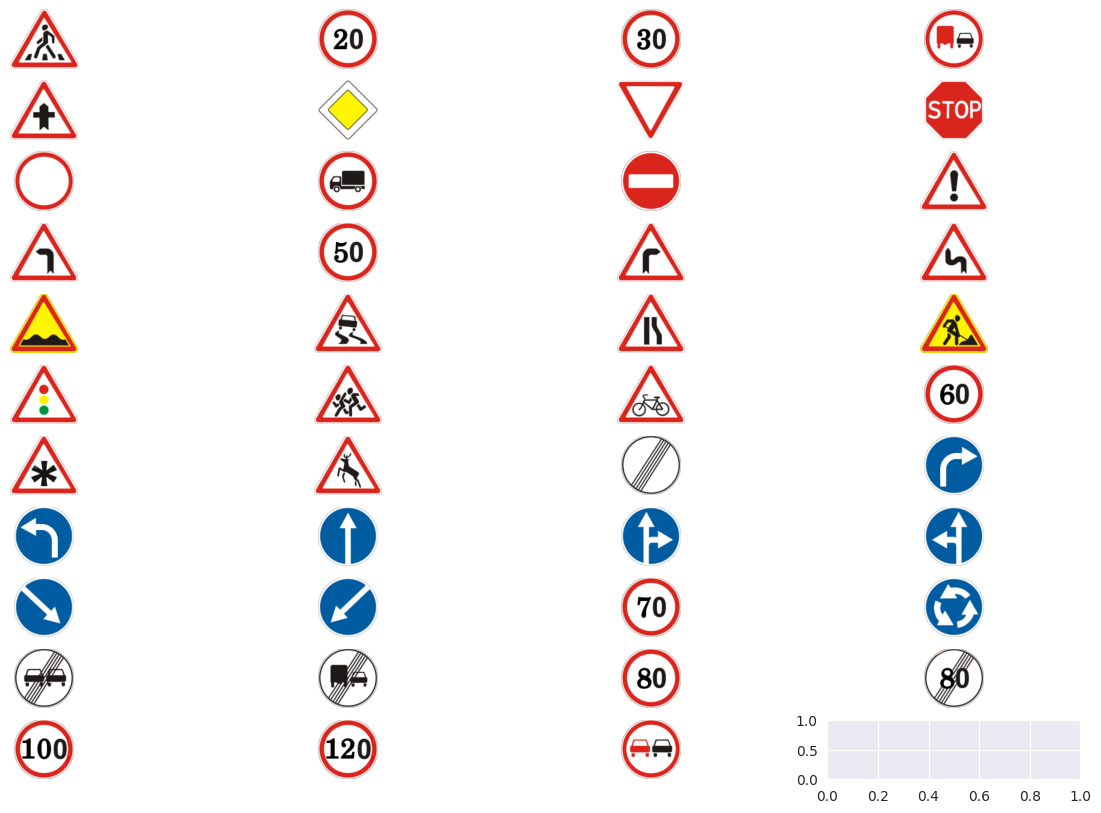

In [7]:
signs = [os.path.join(traffic_sign_dataset_dir, meta_df.Path.to_list()[i]) for i in range(43)]
fig, axes = plt.subplots(11, 4, figsize=(15, 10))
for i, image_path in enumerate(signs):
    image = Image.open(image_path)
    row = i // 4
    col = i % 4
    axes[row, col].imshow(image)
    axes[row, col].axis('off')

plt.show();

In [8]:
#exploring Train.csv file

print("")
print("------------------------------------------------")
print(train_df.head())
print("------------------------------------------------")

print("number of Training Samples in the dataset:", train_df.shape[0])
print("number of Test Samples in the dataset:", test_df.shape[0])
print("number of Classes in the dataset:", train_df["ClassId"].nunique())
print("The Maximum Width:", train_df["Width"].max())
print("The Maximum Height:", train_df["Height"].max())


------------------------------------------------
   Width  Height  Roi.X1  Roi.Y1  Roi.X2  Roi.Y2  ClassId  \
0     27      26       5       5      22      20       20   
1     28      27       5       6      23      22       20   
2     29      26       6       5      24      21       20   
3     28      27       5       6      23      22       20   
4     28      26       5       5      23      21       20   

                             Path  
0  Train/20/00020_00000_00000.png  
1  Train/20/00020_00000_00001.png  
2  Train/20/00020_00000_00002.png  
3  Train/20/00020_00000_00003.png  
4  Train/20/00020_00000_00004.png  
------------------------------------------------
number of Training Samples in the dataset: 39209
number of Test Samples in the dataset: 12630
number of Classes in the dataset: 43
The Maximum Width: 243
The Maximum Height: 225


## The Distribution of the Class labels in the dataset 

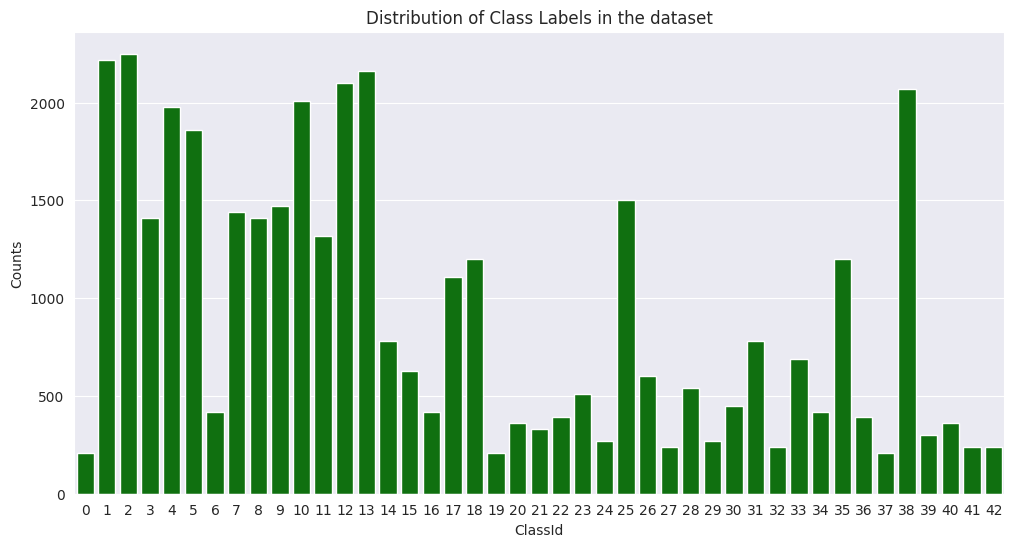

In [9]:
classes = train_df["ClassId"].value_counts().head(43)
plt.figure(figsize=(12, 6))
plt.title("Distribution of Class Labels in the dataset")
plt.ylabel('Counts')
plt.xlabel('Classes')

sns.barplot(y=classes.values, x=classes.index, color='g');

## Plotting samples of the Traffic signs 

In [10]:
train_data_path = os.path.join(traffic_sign_dataset_dir, 'Train')
valid_data_path = os.path.join(traffic_sign_dataset_dir, 'Test')

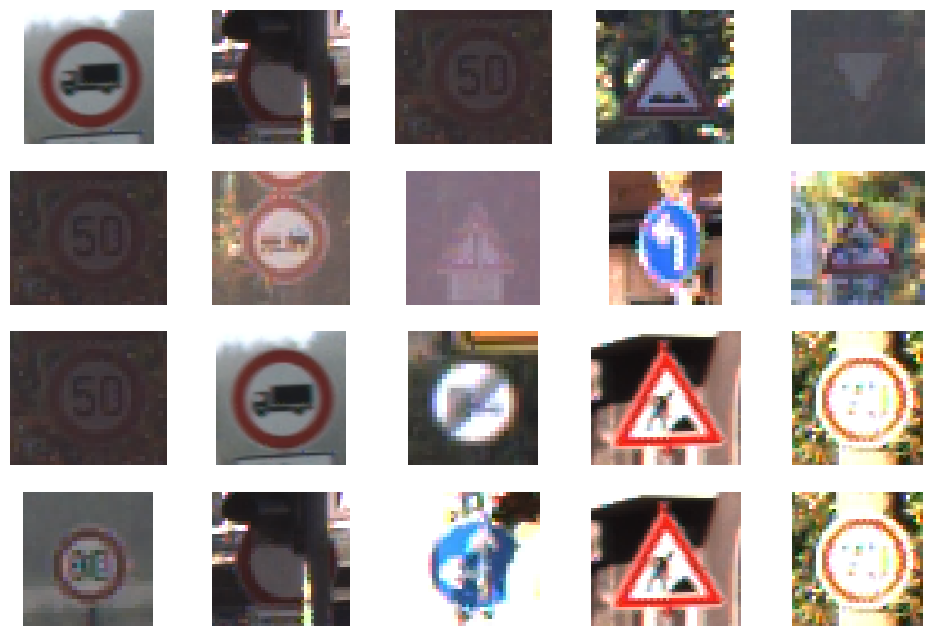

In [11]:
folder_names = [os.path.join(train_data_path, str(i)) for i in random.choices(range(43), k=20)]
file_names = [os.path.join(fldr, os.listdir(fldr)[0]) for fldr in folder_names]

fig, axes = plt.subplots(4, 5, figsize=(12, 8))
for i, image_path in enumerate(file_names):
    image = Image.open(image_path)
    row = i // 5
    col = i % 5
    axes[row, col].imshow(image)
    axes[row, col].axis('off')

plt.show();

In [12]:
training_set = TSignsDataset(train_df, traffic_sign_dataset_dir, transform=transforms)
validation_set = TSignsDataset(test_df, traffic_sign_dataset_dir, transform=transforms)

# Create the model

In [15]:
# print(os.getenv("PYTORCH_CUDA_ALLOC_CONF"))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device is:", device)
model = ResNet50(img_channel=3, num_classes=43)
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 5
batch_size = 4
out_path = os.path.join(os.getcwd(), "traffic_sign_model/best_model"+ "_cuda.pt" if torch.cuda.is_available() else "_cpu.pt")

#train the model
# Train(model, device, criterion, optimizer, num_epochs, batch_size, getDataloaders(batch_size, training_set, validation_set), out_path)

device is: cuda


# Loading The trained Model 

In [17]:
model.load_state_dict(torch.load(out_path))

<All keys matched successfully>

In [20]:
#
# Resnet is required to be put in evaluation mode in order
# to do prediction / evaluation
#
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): block(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (identity_downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
    

In [21]:
from torchvision import transforms
# Create a preprocessing pipeline
preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )])


In [22]:
import os
img_path = os.path.join(os.path.dirname((os.getcwd())), "dataset/test_data/test1.jpg")
# img_path = "/home/a-schulz/kaggle/gtsrb-german-traffic-sign/Meta/2.png"

In [23]:
# Using cv2 to load image
# import cv2

# # Function to load and transform the image
# def load_and_transform_image(image_path):
#     # Load the image using OpenCV
#     image = cv2.imread(image_path)

#     # Convert the image from BGR (OpenCV's default) to RGB
#     image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

#     # Define the transformations to be applied
#     transform = transforms.Compose([
#         transforms.ToPILImage(),              # Convert NumPy array to PIL Image
#         transforms.Resize((224, 224)),        # Resize the image to 224x224 pixels
#         transforms.ToTensor(),                # Convert PIL Image to PyTorch Tensor
#         transforms.Normalize(                 # Normalize the image with mean and standard deviation
#             mean=[0.485, 0.456, 0.406],       # These values are for ImageNet-pretrained models
#             std=[0.229, 0.224, 0.225]
#         ),
#     ])

#     # Apply the transformations to the image
#     transformed_image = transform(image)

#     return transformed_image



# if os.path.isfile(img_path):
#     img = load_and_transform_image(img_path)

# #
# # Reshape, crop, and normalize the input tensor for feeding into network for evaluation
# #
# batch_img_cat_tensor = torch.unsqueeze(img, 0)

# #
# # Get the predictions of image as scores related to how the loaded image
# # matches with 1000 ImageNet classes. The variable, out is a vector of 1000 scores
# #
# out = model(batch_img_cat_tensor)

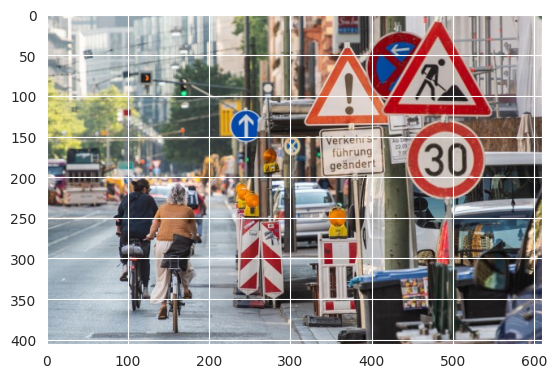

In [24]:
# Load the image
from PIL import Image
img_cat = Image.open(img_path).convert('RGB')
plt.imshow(img_cat)
# Pass the image for preprocessing and the image preprocessed
img_cat_preprocessed = preprocess(img_cat)
img_cat_preprocessed = img_cat_preprocessed.to(device)  # Move tensor to the same device as the model

# Reshape, crop, and normalize the input tensor for feeding into the network for evaluation
batch_img_cat_tensor = torch.unsqueeze(img_cat_preprocessed, 0)

# Make sure the model is on the same device as the input tensor
model.to(device)

# Get the predictions of the image
out = model(batch_img_cat_tensor)

In [25]:
with open(os.path.join(os.getcwd(),'traffic_sign_model/classid_label.csv')) as f:
    labels = [line.strip() for line in f.readlines()]
#
# Find the index (tensor) corresponding to the maximum score in the out tensor.
# Torch.max function can be used to find the information
#
_, index = torch.max(out, 1)
#
# Find the score in terms of percentage by using torch.nn.functional.softmax function
# which normalizes the output to range [0,1] and multiplying by 100
#
percentage = torch.nn.functional.softmax(out, dim=1)[0] * 100
#
# Print the name along with score of the object identified by the model
#
print(labels[index[0]], percentage[index[0]].item())
#
# Print the top 5 scores along with the image label. Sort function is invoked on the torch to sort the scores.
#
_, indices = torch.sort(out, descending=True)
[(labels[idx], percentage[idx].item()) for idx in indices[0][:5]]

39,drive along left 99.58190155029297


[('39,drive along left', 99.58190155029297),
 ('1,30 km/h', 0.15813076496124268),
 ('37,must turn left or straight', 0.14314918220043182),
 ('ClassId,Label', 0.09644920378923416),
 ('41,end no overtaking', 0.0040016258135437965)]